In [53]:
import os
import numpy as np
import codecs
path_baptiste = "/home/baptiste/Documents/data/train"
path_igor = "C:/Users/Igor/Documents/Master Data Science/Big Data Analytics/Projet/Data/train"
path_sofia = "/Users/Flukmacdesof/data 2/train"



#assumes labelled data ra stored into a positive and negative folder
#returns two lists one with the text per file and another with the corresponding class 
def loadLabeled(path):

	rootdirPOS =path+'/pos'
	rootdirNEG =path+'/neg'
	data=[]
	Class=[]
	count=0
	for subdir, dirs, files in os.walk(rootdirPOS):
		
		for file in files:
			with codecs.open(rootdirPOS+"/"+file, 'r',encoding="utf-8") as content_file:
				content = content_file.read() #assume that there are NO "new line characters"
				data.append(content)
	tmpc1=np.ones(len(data))
	for subdir, dirs, files in os.walk(rootdirNEG):
		
		for file in files:
			with codecs.open(rootdirNEG+"/"+file, 'r',encoding="utf-8") as content_file:
				content = content_file.read() #assume that there are NO "new line characters"
				data.append(content)
	tmpc0=np.zeros(len(data)-len(tmpc1))
	Class=np.concatenate((tmpc1,tmpc0),axis=0)
	return data,Class
#loads unlabelled data	
#returns two lists
#one with the data per file and another with the respective filenames (without the file extension)
def loadUknown(path):
	rootdir=path
	data=[]
	names=[]
	for subdir, dirs, files in os.walk(rootdir):
		for file in files:
			with open(rootdir+"/"+file, 'r') as content_file:
				content = content_file.read() #assume that there are NO "new line characters"
				data.append(content)
				names.append(file.split(".")[0])
	return data,names

## Data loading

In [54]:
data = loadLabeled(path_baptiste)
reviews = data[0]

## First data cleaning (Igor):
- Remove all the HTML symbols

In [17]:
# Remove HLML signs
HTMLlist = ['<br />']

for idx, review in enumerate(reviews):
    for word in HTMLlist:
        reviews[idx] = review.replace(word,'')

## Creating new features : Other ideas to try

- Find N-grams where it may start with a CAPITAL (As for the movie names and actor's names)


## Feature creation (Sofia):
- List punctuation (various form)
- Find smiley

In [4]:
excla = [0]*len(reviews)
inter = [0]*len(reviews)
susp = [0]*len(reviews)
for i, review in enumerate(reviews):
    for char in review:
        if char == "?":
            inter[i] += 1
        elif char == "!":
            excla[i] += 1

In [5]:
from nltk.tokenize.casual import TweetTokenizer
ttoken = TweetTokenizer(reduce_len=True)
tokenized_reviews = []

for review in reviews:
    tokenized_reviews.append(ttoken.tokenize(review))

In [6]:
for i, review in enumerate(tokenized_reviews):
    for word in review:
        if word == "...":
            susp[i] += 1

ValueError: x must have at least one data point

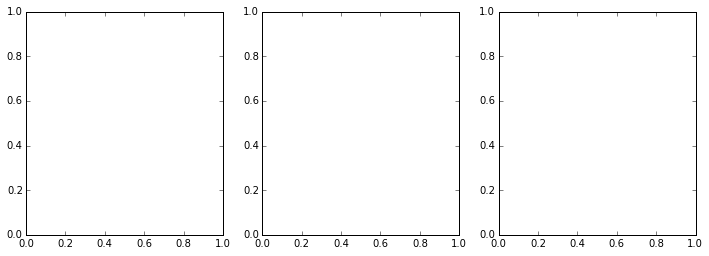

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].hist(excla, bins=50)[2]
ax[1].hist(inter, bins=50)[2]
ax[2].hist(susp, bins=50)[2]

In [ ]:
u_excla = pd.unique(excla)
u_inter = pd.unique(inter)
u_susp = pd.unique(susp)


plot_excla = {}
plot_inter = {}
plot_susp = {}
dicts = [
    [np.array(plot_excla), sorted(u_excla), excla],
    [np.array(plot_inter), sorted(u_inter), inter], 
    [np.array(plot_susp), sorted(u_susp), susp]
]
for dic in dicts: 
    dic[0]={key: np.mean(data[1][np.where(dic[2]==key)]) for key in dic[1]}
    
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(3) :
    ax[i].plot(*zip(*sorted(dicts[i][0].items())))
    ax[i].set_ylim([0,1])

## Feature creation (Igor): 
- Length of the review
- Grad given in the review
- Movie mentionned in the review

In [8]:
# The movie list has to be completed
# - Find a list of the movie so as it matches some in the reviews : www.imdb.com
movie_list = ['Titanic']

rev_length = []
rev_grade = []
rev_movie = []

for review in reviews:
    # Length of the review
    rev_length.append(len(review))
    
    # Grade/Mark in the review
    for idx, char in enumerate(review):
        if char == '/' and idx < len(review)-2:
            if review[idx+1] == '1' and review[idx+2] == '0':
                rev_grade.append(review[idx-1])
        else:
            rev_grade.append(-1)
    # Movie in the review
    for movie_name in movie_list:
        if movie_name in review:
            rev_movie.append(movie_name)
            #break
        else:
            rev_movie.append('no movie')

## Second Data Cleaning (After the features creation) :
 - Punctuation
 - Stop Words


In [18]:
#import sys
#reload(sys)  
#sys.setdefaultencoding('Cp1252')


In [19]:
print sys.getdefaultencoding()

In [55]:
# Remove punctuation, lower all characters
# exclude = {',' ,'+', '<', ':', '/', ']', '(', ')', '{', '"', '_', '?', '@', '}', ...}
import string
exclude = set(string.punctuation)
for idx, review in enumerate(reviews):
    reviews[idx] = ''.join([w for w in review.lower() if w not in exclude])
    
    
# Remove stop words based on the given list - To be changed depending on the needs
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
for idx, review in enumerate(reviews):
    reviews[idx] = ''.join([w for w in review if w not in stopwords])
    #problème de codage à voir

KeyboardInterrupt: 

## Third Data Cleaning (Baptiste): 
- Stemmisation

In [56]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [61]:

# Steeming -> Reduce words to their initial mining

for idx, review in enumerate(reviews):
    for word in review: 
        reviews[idx] = ''.join([stemmer.stem(word)+' ' for word in review.split()])

KeyboardInterrupt: 

## Tf - Idf Matrix (Igor)

#### To be upgraded with new tf and idf functions!

##  CSV Creation (Baptiste):

Create 5 csv : train_train.csv, train_test.csv, y_train_train.csv, y_train_test.csv, test.csv